<a href="https://colab.research.google.com/github/YUMVOLKOVA/Topic-Modeling/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Topic Modeling
#### Волкова Юлия, МОиАД, 2 курс

### Задание
Постройте тематическую модель обращений в YouTrack от внешних пользователей в течение последних пяти релизов PyCharm. Визуализируйте её так, чтобы по визуализации можно было бы (хотя бы попытаться) ответить на два следующих вопроса:
1. Каковы основные причины для обращений в релизе 2020.2?
2. Какие новые проблемы добавились в релизе 2020.3 и какие ушли, по сравнению с релизом 2020.2?


### Данные

Считываем данные 

In [1]:
import tqdm.notebook as tq
import pandas as pd
import io
import re
import numpy

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

import gensim.corpora as corpora
from gensim.corpora import Dictionary  #This module implements the concept of a Dictionary – a mapping between words and their integer ids.
# doc2bow - Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

from gensim.models import LdaMulticore


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_json(io.StringIO(uploaded['pycharm_issues.json'].decode('utf-8')), lines=True)

In [3]:
# df = pd.read_json('pycharm_issues.json', lines=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_json('/content/drive/MyDrive/Prod/pycharm_issues.json', lines=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Посмотрим на наши данные 

In [5]:
df

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]
...,...,...,...,...,...
22009,PY-51597,1636879129851,Intellij don't recognize python3 installed by ...,"\n\nIU-212.5457.46, JRE 11.0.12+7-b1504.40x64 ...",[]
22010,PY-51594,1636908525899,url tag in django template that uses filters o...,When using the {% url %} tag in a Django templ...,[]
22011,PY-51588,1636866008572,Variable incorrectly marked as used,"Hi, in this example, tha variable 'idocking' i...",[]
22012,PY-51595,1636912616563,Warn on invalid iterable unpack,```python\nimport time\n\ndef foo() -> float:\...,[2021.2]


"...в течение последних пяти релизов ..." $->$ фильтруем датасет по пяти последним значениям Affected versions

In [6]:
import itertools
last_five = sorted(list(set(list(itertools.chain(*df['Affected versions'])))))[-5:]

In [7]:
last_five = [[i] for i in last_five]
last_five

[['2020.2'], ['2020.3'], ['2021.1'], ['2021.2'], ['2021.3']]

In [8]:
for i in tq.tqdm(range(len(df['Affected versions']))):  
  if df.loc[(i, 'Affected versions')] not in last_five:
    df = df.drop(i)

  0%|          | 0/22014 [00:00<?, ?it/s]

In [9]:
df.reset_index(inplace=True, drop=True)
df

,idReadable,created,summary,description,Affected versions
0,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3]
1,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2]
2,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1]
3,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1]
4,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3]
...,...,...,...,...,...
2180,PY-51608,1636987696450,Breakpoints not always hit in multi-threaded app,# Steps to Reproduce\n\nCreate a project using...,[2021.2]
2181,PY-51621,1637063283050,code insighte: Quick solution (+error) instead...,"Hi,\n**What I do:**\nI open huge JSON file (ab...",[2021.2]
2182,PY-51614,1637012454711,"IDE keeps disabling Python plugin, I get and e...",Here is the job log.\n\nI am unable to use the...,[2021.2]
2183,PY-51605,1636977168955,"Better ""Invalid Python SDK"" handling",Quite often OS (usually macOS) or Python updat...,[2021.2]


Посмотрим, сколько всего записей по каждому релизу

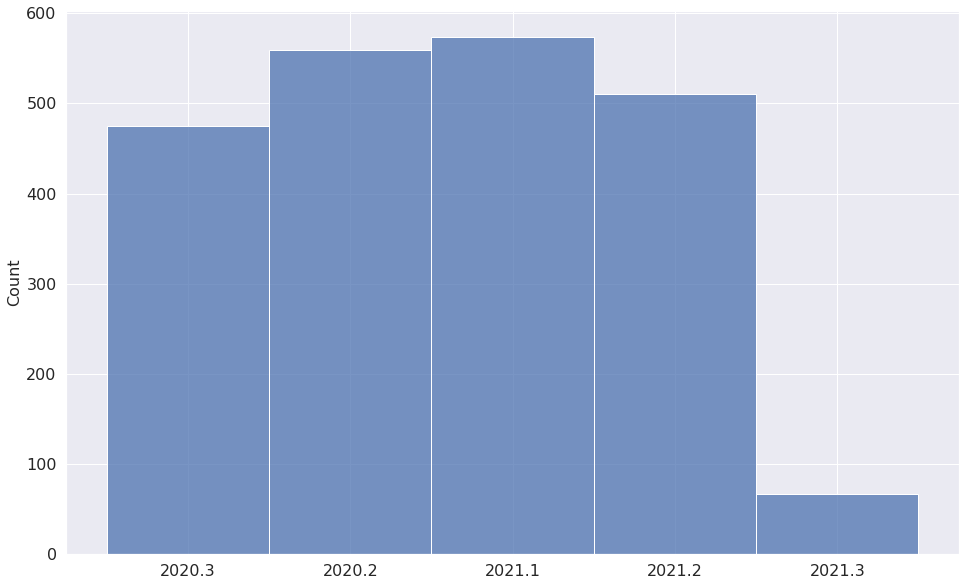

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
sns.histplot(data=df, x=list(itertools.chain(*df['Affected versions'])))
plt.show()

Меньше всего записей в релизе "2021.3" (меньше 100). 

Для "2020.3 и "2020.2" количество примерно одинаковое (~500). Их мы и будем анализировать во второй части работы.


Посмотрим на содержимое 'summary' и 'description' для одной записи

In [11]:
df['summary'][0]

'Running subprocesses with Popen inside unittests can hang execution for too long'

In [12]:
print(df['description'][0])

I have the following unittest:

```
class MyTest(unittest.TestCase):
    def test(self):
        import subprocess
        import sys
        import time

        start = time.monotonic()

        try:
            subprocess.run([sys.executable, '-c', 'print("hello"); import time; time.sleep(10)'],
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=2)
        except subprocess.TimeoutExpired:
            pass

        try:
            subprocess.run([sys.executable, '-c', 'print("hello"); import time; time.sleep(10)'],
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=2)
        except subprocess.TimeoutExpired:
            pass

        end = time.monotonic()

        print(end - start)
```

When `timeout` equal `2` execution roughly takes 4 seconds as expected. But if you change `timeout` to `0.1`. execution will take ~10 seconds.



Поработаем с колонкой 'summary'

### Предобработка текста

Удаляем пунктуацию и ненужные символы

In [13]:
df['cleaned_summary'] = df['summary'].map(lambda x: re.sub('[,\.!?\-\+\(\)\"\`\~:]', '', x))
df['cleaned_summary'] = df['cleaned_summary'].map(lambda x: re.sub('\s+', ' ', x))
df['cleaned_summary'] = df['cleaned_summary'].map(lambda x: x.lower())
df['cleaned_summary'] = df['cleaned_summary'].map(lambda x: x.replace("i'm", 'i am').replace("n't", ' not'))
df

,idReadable,created,summary,description,Affected versions,cleaned_summary
0,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3],running subprocesses with popen inside unittes...
1,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2],full project optimize imports alters library f...
2,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1],dataframe autoupdate does not work with action...
3,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1],powershell prompt does not show virtualenv
4,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3],project requirements are not detected from set...
...,...,...,...,...,...,...
2180,PY-51608,1636987696450,Breakpoints not always hit in multi-threaded app,# Steps to Reproduce\n\nCreate a project using...,[2021.2],breakpoints not always hit in multithreaded app
2181,PY-51621,1637063283050,code insighte: Quick solution (+error) instead...,"Hi,\n**What I do:**\nI open huge JSON file (ab...",[2021.2],code insighte quick solution error instead of ...
2182,PY-51614,1637012454711,"IDE keeps disabling Python plugin, I get and e...",Here is the job log.\n\nI am unable to use the...,[2021.2],ide keeps disabling python plugin i get and er...
2183,PY-51605,1636977168955,"Better ""Invalid Python SDK"" handling",Quite often OS (usually macOS) or Python updat...,[2021.2],better invalid python sdk handling


Убираем стоп-слова и токенизируем

gensim.utils.simple_preprocess() - Convert a document into a list of tokens.


In [14]:
list_summary = df['cleaned_summary'].tolist()

In [15]:
final_out = []
for text in tq.tqdm(list_summary):
  preprocess_text = simple_preprocess(str(text), deacc=True)
  tmp = []
  for word in preprocess_text:
    if word not in stop_words:
      tmp.append(word)
  final_out.append(tmp)
# final_out

  0%|          | 0/2185 [00:00<?, ?it/s]

Преобразуем данные в такой формат, который можно было бы использовать в LDA

In [16]:
dict_w_id = Dictionary(final_out)
d2bow = [dict_w_id.doc2bow(text) for text in final_out]

In [17]:
d2bow[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

### Модель: LDA

Количество топиков возьмем 50

In [18]:
lda_model = LdaMulticore(corpus=d2bow,
                        id2word=dict_w_id,
                        num_topics=50, 
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [19]:
sorted(lda_model.print_topics(num_topics=10)) #10 самых важных тем

[(2,
  '0.208*"interpreter" + 0.107*"using" + 0.080*"wsl" + 0.068*"docker" + 0.042*"remote" + 0.036*"python" + 0.035*"compose" + 0.035*"ssh" + 0.030*"dockercompose" + 0.021*"sciview"'),
 (9,
  '0.164*"warning" + 0.120*"test" + 0.071*"unexpected" + 0.059*"button" + 0.049*"dict" + 0.038*"case" + 0.032*"result" + 0.031*"runner" + 0.025*"itemsview" + 0.025*"autodetect"'),
 (12,
  '0.183*"function" + 0.102*"type" + 0.090*"without" + 0.043*"nested" + 0.040*"hint" + 0.038*"defined" + 0.037*"user" + 0.037*"hinting" + 0.023*"definition" + 0.021*"outside"'),
 (20,
  '0.472*"python" + 0.174*"console" + 0.031*"issue" + 0.031*"slow" + 0.021*"save" + 0.013*"auto" + 0.013*"always" + 0.012*"managepy" + 0.010*"hidden" + 0.010*"queue"'),
 (26,
  '0.258*"file" + 0.103*"debugging" + 0.092*"script" + 0.076*"object" + 0.071*"stop" + 0.025*"poetry" + 0.021*"produces" + 0.021*"copy" + 0.019*"bad" + 0.015*"started"'),
 (28,
  '0.388*"error" + 0.079*"broken" + 0.052*"report" + 0.036*"unused" + 0.031*"usages" + 

Посчитаем Coherence Score для данной модели

In [20]:
from gensim.models import CoherenceModel

In [21]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_out, dictionary=dict_w_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6016160621850803


Визуализация

In [22]:
%%capture
!pip install pyLDAvis
!pip install --upgrade pandas==1.2
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 
pyLDAvis.enable_notebook()

In [23]:
result = pyLDAvis.gensim_models.prepare(lda_model, d2bow, dict_w_id, mds="mmds")

In [24]:
result

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.417655  0.276167       1        1  4.183891
20    -0.176367 -0.465964       2        1  3.678100
44    -0.414966 -0.258861       3        1  3.146711
23     0.470015  0.035116       4        1  2.836740
32    -0.002905  0.458462       5        1  2.727935
7      0.404001 -0.206560       6        1  2.718705
6      0.291323 -0.331791       7        1  2.484702
27    -0.408471  0.137321       8        1  2.464607
16    -0.326158 -0.189271       9        1  2.404312
38     0.137919  0.437041      10        1  2.357332
25     0.218305  0.361951      11        1  2.318404
13    -0.286569  0.358022      12        1  2.294516
21    -0.168019  0.378406      13        1  2.196047
46     0.168427 -0.318512      14        1  2.122053
40     0.410275  0.148021      15        1  2.100493
14    -0.283114 -0.287328      16        1  2.082384
5      0.040556 -0.418131      17        1  2.078788
9     -0.400940 -0.100188      18        1  2.077338
10    -0.184220 -0.126226      19        1  2.053053
35    -0.340757  0.069624      20        1  2.017588
47     0.181945 -0.399333      21        1  1.967483
39    -0.063111 -0.395041      22        1  1.944965
1      0.417082 -0.091409      23        1  1.936478
12     0.113308 -0.239371      24        1  1.935312
28    -0.426631  0.005652      25        1  1.901206
4      0.036108  0.344427      26        1  1.891556
36     0.344324  0.252545      27        1  1.795448
42     0.277655 -0.230949      28        1  1.787448
43     0.172740 -0.070822      29        1  1.749124
26     0.346282  0.002173      30        1  1.730329
24    -0.195978 -0.331689      31        1  1.724897
33    -0.269435  0.188387      32        1  1.707205
18     0.065670  0.186574      33        1  1.698459
0     -0.166870  0.014660      34        1  1.692036
15    -0.283339 -0.047435      35        1  1.684317
17     0.252286  0.271467      36        1  1.683566
48    -0.076668  0.366618      37        1  1.648379
8     -0.174604  0.260100      38        1  1.641509
22     0.297366  0.147870      39        1  1.638190
49     0.128824  0.250265      40        1  1.580761
41    -0.058886  0.200262      41        1  1.570464
19     0.022620 -0.296234      42        1  1.566095
29    -0.119134 -0.264864      43        1  1.513852
30     0.210213  0.035700      44        1  1.493063
45    -0.010092  0.041307      45        1  1.488802
3     -0.051487 -0.146044      46        1  1.469659
37     0.279777 -0.125671      47        1  1.432755
34     0.040577 -0.093753      48        1  1.427663
11    -0.152308  0.115804      49        1  1.250543
31     0.131084  0.091505      50        1  1.104736, topic_info=           Term        Freq       Total Category  logprob  loglift
58       python  271.000000  271.000000  Default  30.0000  30.0000
35      pycharm  235.000000  235.000000  Default  29.0000  29.0000
65         code  127.000000  127.000000  Default  28.0000  28.0000
190       error  106.000000  106.000000  Default  27.0000  27.0000
79         type  230.000000  230.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2342   additive    0.793238    1.618096  Topic50  -5.2983   3.7927
2343    stacked    0.793238    1.618096  Topic50  -5.2983   3.7927
424   directive    0.567831    1.392689  Topic50  -5.6326   3.6084
2124     dotted    0.541970    1.366828  Topic50  -5.6792   3.5805
2019      built    0.448654    1.273512  Topic50  -5.8681   3.4623

[1554 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1086     37  0.886366   ability
2383     18  0.923674      able
1378     37  0.780709  absolute
1633     10  0.771052  abstract
2260     24  0.828255  accepted
...     ...       ...       ...
1899     40  0.835188      yaml
2765     48  0.863191       yes
2449     39  0.571031       yet
2449   

### Анализ 2020.2

In [25]:
df_2020_2 = df.copy()
for i in tq.tqdm(range(len(df_2020_2['Affected versions']))):  
  if df_2020_2.loc[(i, 'Affected versions')] != ['2020.2']:
    df_2020_2 = df_2020_2.drop(i)

  0%|          | 0/2185 [00:00<?, ?it/s]

In [26]:
df_2020_2

,idReadable,created,summary,description,Affected versions,cleaned_summary
1,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2],full project optimize imports alters library f...
8,PY-23558,1491299287883,Django: Relative paths in include and extends ...,Since Django 1.10* it's possible to use relati...,[2020.2],django relative paths in include and extends t...
9,PY-24622,1496901895623,Python stub: unresolved submodule name string ...,given a python stub file package with the foll...,[2020.2],python stub unresolved submodule name string i...
15,PY-25291,1500917245745,Datetime Index for DataFrame is displayed with...,The new Data View in 172.3317.82 fixs the issu...,[2020.2],datetime index for dataframe is displayed with...
21,PY-26947,1510393814382,Class variable mistaken as module global variable,```\nv = 5\n\nclass C:\n v = 3\n```\n\nIn t...,[2020.2],class variable mistaken as module global variable
...,...,...,...,...,...,...
942,PY-46623,1611451172232,Deleting a functools.cached_property throws a ...,*What steps will reproduce the problem?*\n\n``...,[2020.2],deleting a functoolscached_property throws a w...
950,PY-46671,1611750268571,Unexpected kerning on library sources,"Hi,\nI've suddenly opened bs4 sources on pycha...",[2020.2],unexpected kerning on library sources
960,PY-46680,1611768468063,Jupyter notebook preview - where are the Javas...,When a widget is not supported in Pycharm's Ju...,[2020.2],jupyter notebook preview where are the javascr...
984,PY-46875,1612592204203,Tools->Development->Automatic Uploads(Always) ...,What steps will reproduce the problem?\n\n1.Cr...,[2020.2],tools>development>automatic uploadsalways malf...


In [27]:
list_summary = df_2020_2['cleaned_summary'].tolist()
final_out = []
for text in tq.tqdm(list_summary):
  preprocess_text = simple_preprocess(str(text), deacc=True)
  tmp = []
  for word in preprocess_text:
    if word not in stop_words:
      tmp.append(word)
  final_out.append(tmp)
# dict_w_id = Dictionary(final_out)
d2bow_2 = [dict_w_id.doc2bow(text) for text in final_out]
topic_2020_2 = lda_model.get_document_topics(d2bow_2)
topic_2020_2

  0%|          | 0/559 [00:00<?, ?it/s]

In [28]:
len(topic_2020_2)

559

In [29]:
show_2020_2 = pyLDAvis.gensim_models.prepare(lda_model, d2bow_2, dict_w_id, mds="mmds")

### 2020.3

In [30]:
df_2020_3 = df.copy()
for i in tq.tqdm(range(len(df_2020_3['Affected versions']))):  
  if df_2020_3.loc[(i, 'Affected versions')] != ['2020.3']:
    df_2020_3 = df_2020_3.drop(i)

  0%|          | 0/2185 [00:00<?, ?it/s]

In [31]:
df_2020_3

,idReadable,created,summary,description,Affected versions,cleaned_summary
0,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3],running subprocesses with popen inside unittes...
4,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3],project requirements are not detected from set...
33,PY-29891,1525391390656,PyCharm doesn't infer AsyncContextManager type...,**What steps will reproduce the problem?**\nCo...,[2020.3],pycharm does not infer asynccontextmanager typ...
35,PY-30438,1528901580665,pytest-bdd: support multiline steps,"`pytest-bdd` supports multiline steps, e.g.:\n...",[2020.3],pytestbdd support multiline steps
37,PY-31032,1532615350942,"""Choose symbol"" window (used to search modules...",See attachmenet,[2020.3],choose symbol window used to search modules fo...
...,...,...,...,...,...,...
1278,PY-48400,1618945708109,Pycharm throws permissiondenied error when run...,"I am running on Pycharm CE 2020.03, MAC OS CAT...",[2020.3],pycharm throws permissiondenied error when run...
1369,PY-48646,1620141624419,Render math formulas between $$ in Quick Docum...,Because of its widely used in deep learning de...,[2020.3],render math formulas between $$ in quick docum...
1574,PY-49475,1624905893573,Import module suggest: put top level modules t...,"Hi,\n\neverytime I use `time` module PyCharm s...",[2020.3],import module suggest put top level modules to...
1610,PY-49584,1625488777732,Spell checker finds typo in Unicode character,One picture worth thousand words.\n\nHi!,[2020.3],spell checker finds typo in unicode character


In [32]:
list_summary = df_2020_3['cleaned_summary'].tolist()
final_out = []
for text in tq.tqdm(list_summary):
  preprocess_text = simple_preprocess(str(text), deacc=True)
  tmp = []
  for word in preprocess_text:
    if word not in stop_words:
      tmp.append(word)
  final_out.append(tmp)
# dict_w_id = Dictionary(final_out)
d2bow_3 = [dict_w_id.doc2bow(text) for text in final_out]
topic_2020_3 = lda_model.get_document_topics(d2bow_3)
topic_2020_3

  0%|          | 0/475 [00:00<?, ?it/s]

In [33]:
len(topic_2020_3)

475

In [34]:
show_2020_3 = pyLDAvis.gensim_models.prepare(lda_model, d2bow_3, dict_w_id, mds="mmds")

### Сравнение

In [35]:
show_2020_2

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.427292  0.269107       1        1  4.449016
7     -0.142108 -0.422782       2        1  4.181107
20    -0.442490 -0.226421       3        1  3.904371
23     0.473236  0.034176       4        1  3.282933
32     0.103091  0.451036       5        1  3.255643
44     0.454853 -0.186293       6        1  3.097047
10     0.157066 -0.179013       7        1  2.975720
16    -0.426268  0.087659       8        1  2.595977
5     -0.272018 -0.204188       9        1  2.504239
21     0.107587  0.353630      10        1  2.302927
14     0.223158  0.370627      11        1  2.278528
27    -0.293480  0.279911      12        1  2.196997
40    -0.229622  0.375607      13        1  2.132507
6      0.208173 -0.406397      14        1  2.122747
35     0.401901  0.128537      15        1  2.065149
13    -0.330825 -0.314073      16        1  2.054962
38    -0.019458 -0.458693      17        1  2.052247
8     -0.260291 -0.050304      18        1  2.052094
9     -0.161118 -0.124822      19        1  2.003232
28    -0.350289  0.069479      20        1  1.972603
46     0.234234 -0.317139      21        1  1.946088
42    -0.006733 -0.334457      22        1  1.940394
17     0.218034 -0.051622      23        1  1.931012
4      0.131432 -0.300968      24        1  1.929762
25    -0.377460 -0.122735      25        1  1.923831
47    -0.022497  0.427528      26        1  1.823184
15     0.256615  0.089547      27        1  1.778019
26     0.313126 -0.247730      28        1  1.764494
3      0.052381  0.010638      29        1  1.700528
33     0.362760 -0.079994      30        1  1.635067
36    -0.207227 -0.341008      31        1  1.629907
39    -0.313467  0.172942      32        1  1.625051
19     0.092756  0.119771      33        1  1.602552
41    -0.117567  0.028507      34        1  1.566407
48    -0.376405 -0.023679      35        1  1.545091
49     0.220925  0.207564      36        1  1.530694
12    -0.014151  0.304090      37        1  1.525175
43    -0.111783  0.367204      38        1  1.514202
0      0.327011  0.190248      39        1  1.510818
11     0.111941  0.213745      40        1  1.447925
1     -0.179322  0.302657      41        1  1.434415
22     0.073526 -0.367008      42        1  1.418009
18    -0.139436 -0.250983      43        1  1.347967
34     0.314845  0.010649      44        1  1.315189
37    -0.050529  0.184243      45        1  1.290725
45    -0.030199 -0.195089      46        1  1.222421
29     0.288720 -0.161172      47        1  1.216802
30     0.011398 -0.088816      48        1  1.216322
31    -0.142551  0.106637      49        1  1.187151
24     0.305817  0.299645      50        1  1.000752, topic_info=                 Term       Freq      Total Category  logprob  loglift
58             python  72.000000  72.000000  Default  30.0000  30.0000
35            pycharm  58.000000  58.000000  Default  29.0000  29.0000
190             error  27.000000  27.000000  Default  28.0000  28.0000
65               code  28.000000  28.000000  Default  27.0000  27.0000
105             false  28.000000  28.000000  Default  26.0000  26.0000
...               ...        ...        ...      ...      ...      ...
2276         tutorial   0.228446   0.436574  Topic50  -5.0665   3.9568
2521             repl   0.205316   0.413444  Topic50  -5.1733   3.9044
2582  incompatibility   0.205316   0.413444  Topic50  -5.1733   3.9044
1568            hides   0.179289   0.387417  Topic50  -5.3088   3.8339
2455      traitletspy   0.169324   0.377452  Topic50  -5.3660   3.8028

[1554 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1086     35  0.932384   ability
2383     19  1.081761      able
1378     35  1.086952  absolute
1633     17  1.136329  abstract
2260     37  0.996916  accepted
...     ...       ...       ...
2190     33  0.949942        xc
2421     47  1.225236  

Проблемы с jupyter, django, версиями, дебаггером

In [36]:
show_2020_3

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.464801  0.198596       1        1  3.556696
44    -0.130808 -0.469174       2        1  3.508864
6     -0.076255 -0.396771       3        1  3.173199
20    -0.333731 -0.363222       4        1  3.094678
27     0.176582 -0.407414       5        1  2.899673
46     0.374957 -0.163632       6        1  2.655403
16    -0.353420 -0.230467       7        1  2.582084
23     0.338542 -0.332277       8        1  2.579108
38    -0.356577  0.280841       9        1  2.545968
32     0.349369  0.282214      10        1  2.358279
33    -0.192423 -0.223255      11        1  2.308735
25    -0.388501 -0.140592      12        1  2.269311
18    -0.264701  0.134516      13        1  2.225077
21     0.240248  0.288840      14        1  2.224414
40    -0.443985  0.030992      15        1  2.172628
13    -0.276793  0.376962      16        1  2.141964
14    -0.395414  0.170009      17        1  2.132619
1      0.207352  0.389256      18        1  2.128121
35    -0.386671 -0.057441      19        1  2.120694
39     0.203135 -0.311736      20        1  2.111321
36    -0.196903 -0.324988      21        1  2.101720
0     -0.028630 -0.251174      22        1  2.062527
12     0.306194 -0.208323      23        1  2.022447
7      0.095255 -0.377830      24        1  2.008929
9     -0.045200  0.430920      25        1  1.980510
5      0.025376 -0.394053      26        1  1.966720
43    -0.210567  0.050714      27        1  1.962345
41    -0.017297  0.295148      28        1  1.929360
45    -0.071644 -0.145084      29        1  1.903852
26    -0.143374  0.376055      30        1  1.873317
30    -0.076486  0.108321      31        1  1.865091
24     0.116478  0.157829      32        1  1.811459
22     0.387360 -0.072785      33        1  1.778545
29     0.166782  0.061620      34        1  1.750346
47     0.414286  0.071963      35        1  1.734548
48     0.206369 -0.200506      36        1  1.647779
10     0.292275  0.174783      37        1  1.643830
42    -0.263200 -0.134382      38        1  1.562932
28     0.072913  0.432018      39        1  1.550042
4      0.045605  0.229688      40        1  1.546549
49     0.252286  0.037901      41        1  1.489724
15     0.356937 -0.005747      42        1  1.471069
8      0.108563  0.328363      43        1  1.409553
3      0.180190 -0.070513      44        1  1.341022
37     0.081491 -0.134554      45        1  1.327015
17    -0.343583  0.064265      46        1  1.248299
19    -0.126514  0.275998      47        1  1.236987
34    -0.204237  0.226188      48        1  1.198525
11    -0.008192 -0.020616      49        1  1.014288
31    -0.128242 -0.037463      50        1  0.771837, topic_info=           Term       Freq      Total Category  logprob  loglift
35      pycharm  57.000000  57.000000  Default  30.0000  30.0000
58       python  50.000000  50.000000  Default  29.0000  29.0000
65         code  33.000000  33.000000  Default  28.0000  28.0000
79         type  54.000000  54.000000  Default  27.0000  27.0000
105       false  24.000000  24.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
2342   additive   0.122110   0.306268  Topic50  -5.2983   3.9446
2343    stacked   0.122110   0.306268  Topic50  -5.2983   3.9446
424   directive   0.087411   0.271569  Topic50  -5.6326   3.7306
2124     dotted   0.083430   0.267588  Topic50  -5.6792   3.6987
2019      built   0.069065   0.253223  Topic50  -5.8681   3.5649

[1555 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1086     36  1.005338   ability
2383     25  0.624231      able
1378     36  1.179502  absolute
1633      9  1.095961  abstract
2260     23  0.904939  accepted
...     ...       ...       ...
1402      1  0.895449  wslbased
2190     47  1.325107        xc
2421     34  1.054877       xml
1899     41  0.993511      yaml

In [37]:
list_2020_2 = ['python', 'pycharm', 'code', 'error', 'false', 'interpreter', 'project',
                'type', 'work', 'debugger', 'console', 'cannot', 'file', 'incorrect',
                'run', 'jupyter', 'inspection',  'completion', 'import', 'module',
                'new', 'django', 'using','wrong','window','class','instead','warning', 'positive','string']

In [38]:
list_2020_3 = ['pycharm','python','code','false','type','error','interpreter','project','incorrect','import',
              'work', 'cannot', 'file', 'run', 'console', 'completion', 'new', 'django', 'class', 'list', 'used',
              'function','wrong','working','debugger','show','method','jupyter','module','reference']

Общее в двух релизах

In [39]:
print(*list(set(list_2020_2) & set(list_2020_3)))

completion error run cannot import new django interpreter pycharm work incorrect jupyter code python debugger false console module wrong file project type class


Слова, которые появились в релизе 2020.3

In [40]:
print(*list(set(list_2020_3) - set(list_2020_2)))

method function show list reference used working


Слова, которые ушли из релиза 2020.2

In [41]:
print(*list(set(list_2020_2) - set(list_2020_3)))

instead using inspection window positive warning string


Посмотрим график распределния топиков в двух релизах

In [42]:
def collect_topics(topic_2020_n):
  topics = []
  for topic in topic_2020_n:
    if not topic:
      continue
    probas = []   
    for x in topic:
      probas.append(x[1])
    topics.append(topic[numpy.argmax(probas)][0])
  return topics
t_2 = collect_topics(topic_2020_2)
t_3 = collect_topics(topic_2020_3)

In [43]:
import warnings
warnings.filterwarnings("ignore")

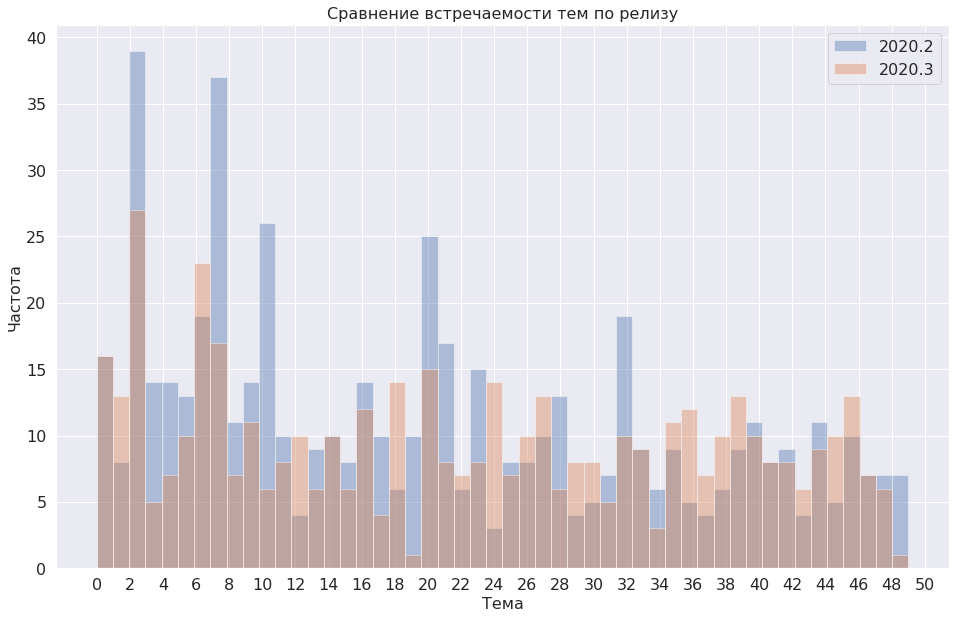

In [44]:
fig, ax = plt.subplots()
i = 2
for a in [t_2, t_3]:
    sns.distplot(a, bins=50, ax=ax, kde=False, label=f'2020.{i}')
    i += 1
# ax.set_xlim([0, 50])
ax.set_xticks(range(0, 51, 2))
ax.legend()
plt.xlabel("Тема")
plt.ylabel("Частота")
plt.title('Сравнение встречаемости тем по релизу')
plt.show()

Голубые полосы отвечают за релиз 2020.2, оранжевые - 2020.3

Из графика видно, что многие проблемы значительно "поубавили свою популярность" с наступлением нового релиза, то есть их смогли решить. Например, топики 3-6, 8-11, 19-23, 32, 49 показали значительный спад частотности. 

Топики 19 и 49 практичеески не встречаются в новом релизе. 

Однако есть и темы, которые стали встречаться чаще, например, тема 1, 7, 9 (большие яркие оранжевые ступеньки). Это потенциальные проблемы релиза, на которые стоит обратить внимание. 